*Вариант 19:* Данные о миллионерах

# Перечислим атрибуты датасета
Rank - Ранг миллионера в списке.

Name - Имя миллионера.

Networth - Чистый капитал миллионера (в долларах США).

Age - Возраст миллионера.

Country - Страна проживания миллионера.

Source - Источник богатства миллионера.

Industry - Отрасль, в которой миллионер заработал своё состояние.

Бизнес-цель: Анализ и визуализация данных о миллионерах для образовательных и информационных программ.

Группировать миллионеров по "интересным" характеристикам для визуализации и информирования общества (например, самые молодые миллионеры, миллионеры с наибольшим капиталом, распределение миллионеров по странам и отраслям и т.д.).

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv("C:/Users/goldfest/Desktop/3 курс/MII/AIM-PIbd-31-LOBASHOV-I-D/static/csv/Forbes Billionaires.csv")
df = df.head(1500)
print(df.head())

   Rank                       Name  Networth  Age        Country  \
0     1                 Elon Musk      219.0   50  United States   
1     2                Jeff Bezos      171.0   58  United States   
2     3  Bernard Arnault & family      158.0   73         France   
3     4                Bill Gates      129.0   66  United States   
4     5            Warren Buffett      118.0   91  United States   

               Source                Industry  
0       Tesla, SpaceX             Automotive   
1              Amazon             Technology   
2                LVMH       Fashion & Retail   
3           Microsoft             Technology   
4  Berkshire Hathaway  Finance & Investments   


# Очистка данных

Удалим несущественные данные

In [13]:
df_cleaned = df.drop(columns=['Name', 'Source'], errors='ignore').dropna()
print(df_cleaned.head()) 

   Rank  Networth  Age        Country                Industry
0     1     219.0   50  United States             Automotive 
1     2     171.0   58  United States             Technology 
2     3     158.0   73         France       Fashion & Retail 
3     4     129.0   66  United States             Technology 
4     5     118.0   91  United States  Finance & Investments 


# Визуализация парных взаимосвязей

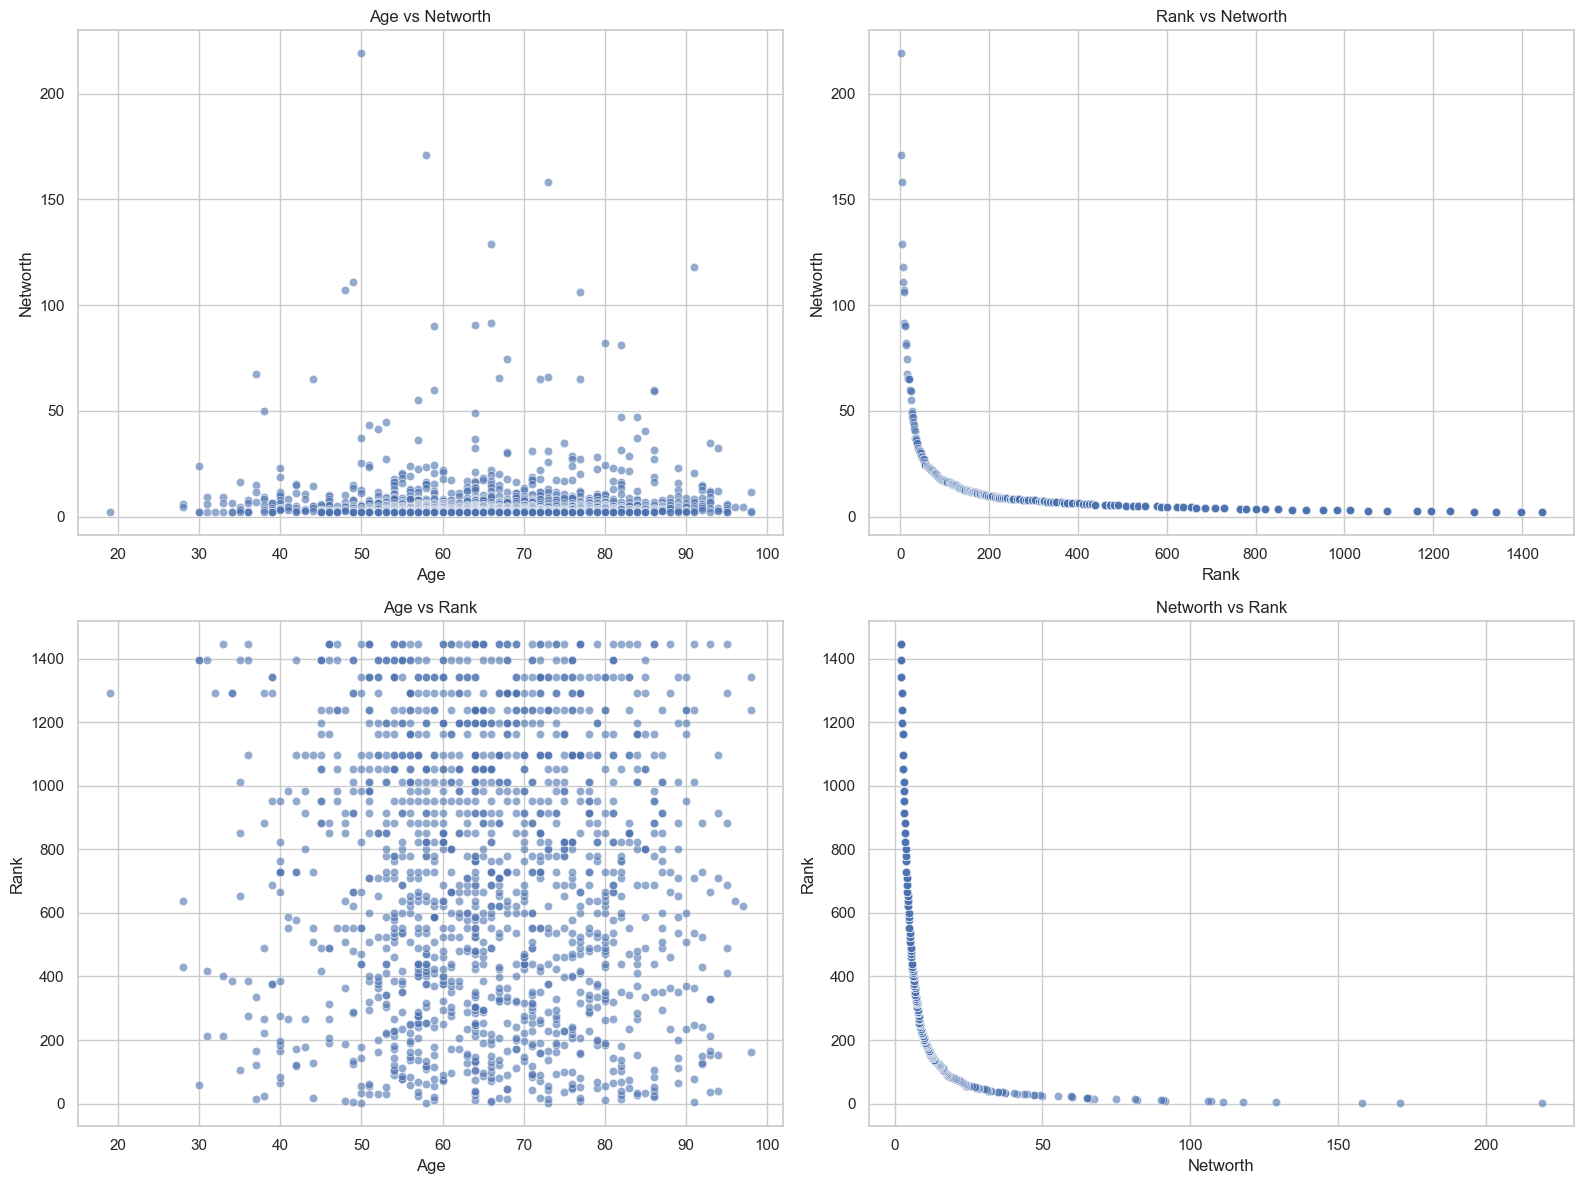

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
sns.scatterplot(x=df_cleaned['Age'], y=df_cleaned['Networth'], alpha=0.6)
plt.title('Age vs Networth')

plt.subplot(2, 2, 2)
sns.scatterplot(x=df_cleaned['Rank'], y=df_cleaned['Networth'], alpha=0.6)
plt.title('Rank vs Networth')

plt.subplot(2, 2, 3)
sns.scatterplot(x=df_cleaned['Age'], y=df_cleaned['Rank'], alpha=0.6)
plt.title('Age vs Rank')

plt.subplot(2, 2, 4)
sns.scatterplot(x=df_cleaned['Networth'], y=df_cleaned['Rank'], alpha=0.6)
plt.title('Networth vs Rank')

plt.tight_layout()
plt.show()


# Стандартизация данных для кластеризации

Стандартизация данных — процесс приведения всех признаков (столбцов) к одному масштабу.

In [15]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

# Проверяем наличие столбцов Country и Industry
if 'Country' in df_cleaned.columns and 'Industry' in df_cleaned.columns:
    # Закодируем столбец Country с помощью One-Hot Encoding
    encoder_country = OneHotEncoder(sparse_output=False)
    country_encoded = encoder_country.fit_transform(df_cleaned[['Country']])
    country_encoded_df = pd.DataFrame(country_encoded, columns=encoder_country.get_feature_names_out(['Country']))

    # Закодируем столбец Industry с помощью One-Hot Encoding
    encoder_industry = OneHotEncoder(sparse_output=False)
    industry_encoded = encoder_industry.fit_transform(df_cleaned[['Industry']])
    industry_encoded_df = pd.DataFrame(industry_encoded, columns=encoder_industry.get_feature_names_out(['Industry']))

    # Удаляем оригинальные столбцы Country и Industry и добавляем закодированные столбцы
    df_cleaned = df_cleaned.drop(columns=['Country', 'Industry'])
    df_cleaned = pd.concat([df_cleaned, country_encoded_df, industry_encoded_df], axis=1)

    # Создаем экземпляр StandardScaler
    scaler = StandardScaler()

    # Применяем стандартизацию к данным
    data_scaled = scaler.fit_transform(df_cleaned)

    # Преобразуем стандартизированные данные обратно в DataFrame для удобства
    df_scaled = pd.DataFrame(data_scaled, columns=df_cleaned.columns)

    # Выводим первые несколько строк стандартизированного DataFrame
    print(df_scaled.head())
else:
    print("Столбцы 'Country' и/или 'Industry' отсутствуют в DataFrame.")


       Rank   Networth       Age  Country_Algeria  Country_Argentina  \
0 -1.738048  15.675541 -1.184396        -0.025828          -0.044766   
1 -1.735688  12.120704 -0.578567        -0.025828          -0.044766   
2 -1.733328  11.157936  0.557363        -0.025828          -0.044766   
3 -1.730968   9.010221  0.027262        -0.025828          -0.044766   
4 -1.728608   8.195571  1.920479        -0.025828          -0.044766   

   Country_Australia  Country_Austria  Country_Belgium  Country_Belize  \
0          -0.147643        -0.068473        -0.025828       -0.025828   
1          -0.147643        -0.068473        -0.025828       -0.025828   
2          -0.147643        -0.068473        -0.025828       -0.025828   
3          -0.147643        -0.068473        -0.025828       -0.025828   
4          -0.147643        -0.068473        -0.025828       -0.025828   

   Country_Brazil  ...  Industry_Logistics   Industry_Manufacturing   \
0       -0.124788  ...            -0.119159       

# Агломеративная (иерархическая) кластеризация

Иерархическая кластеризация — метод машинного обучения, предназначенный для группировки объектов (точек данных) на основе их схожести или расстояния друг от друга. Основная идея заключается в создании структуры кластеров в виде дерева (дендрограммы), которое показывает, как объекты группируются на разных уровнях.

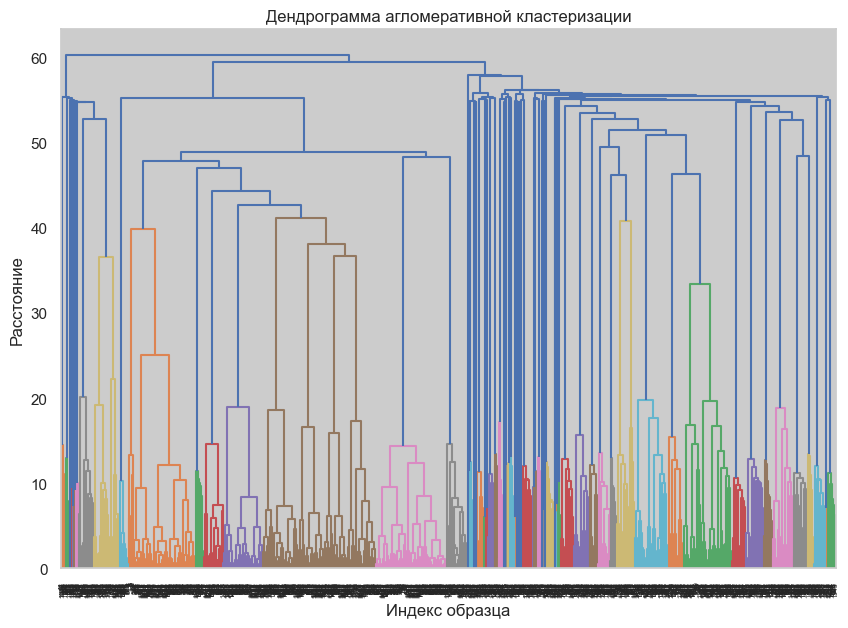

[2 2 2 ... 4 4 2]


In [34]:
linkage_matrix = linkage(data_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Дендрограмма агломеративной кластеризации')
plt.xlabel('Индекс образца')
plt.ylabel('Расстояние')
plt.show()

# Получение результатов кластеризации с заданным порогом
result = fcluster(linkage_matrix, t=56, criterion='distance')
print(result)  # Вывод результатов кластеризации

## Визуализация распределения кластеров

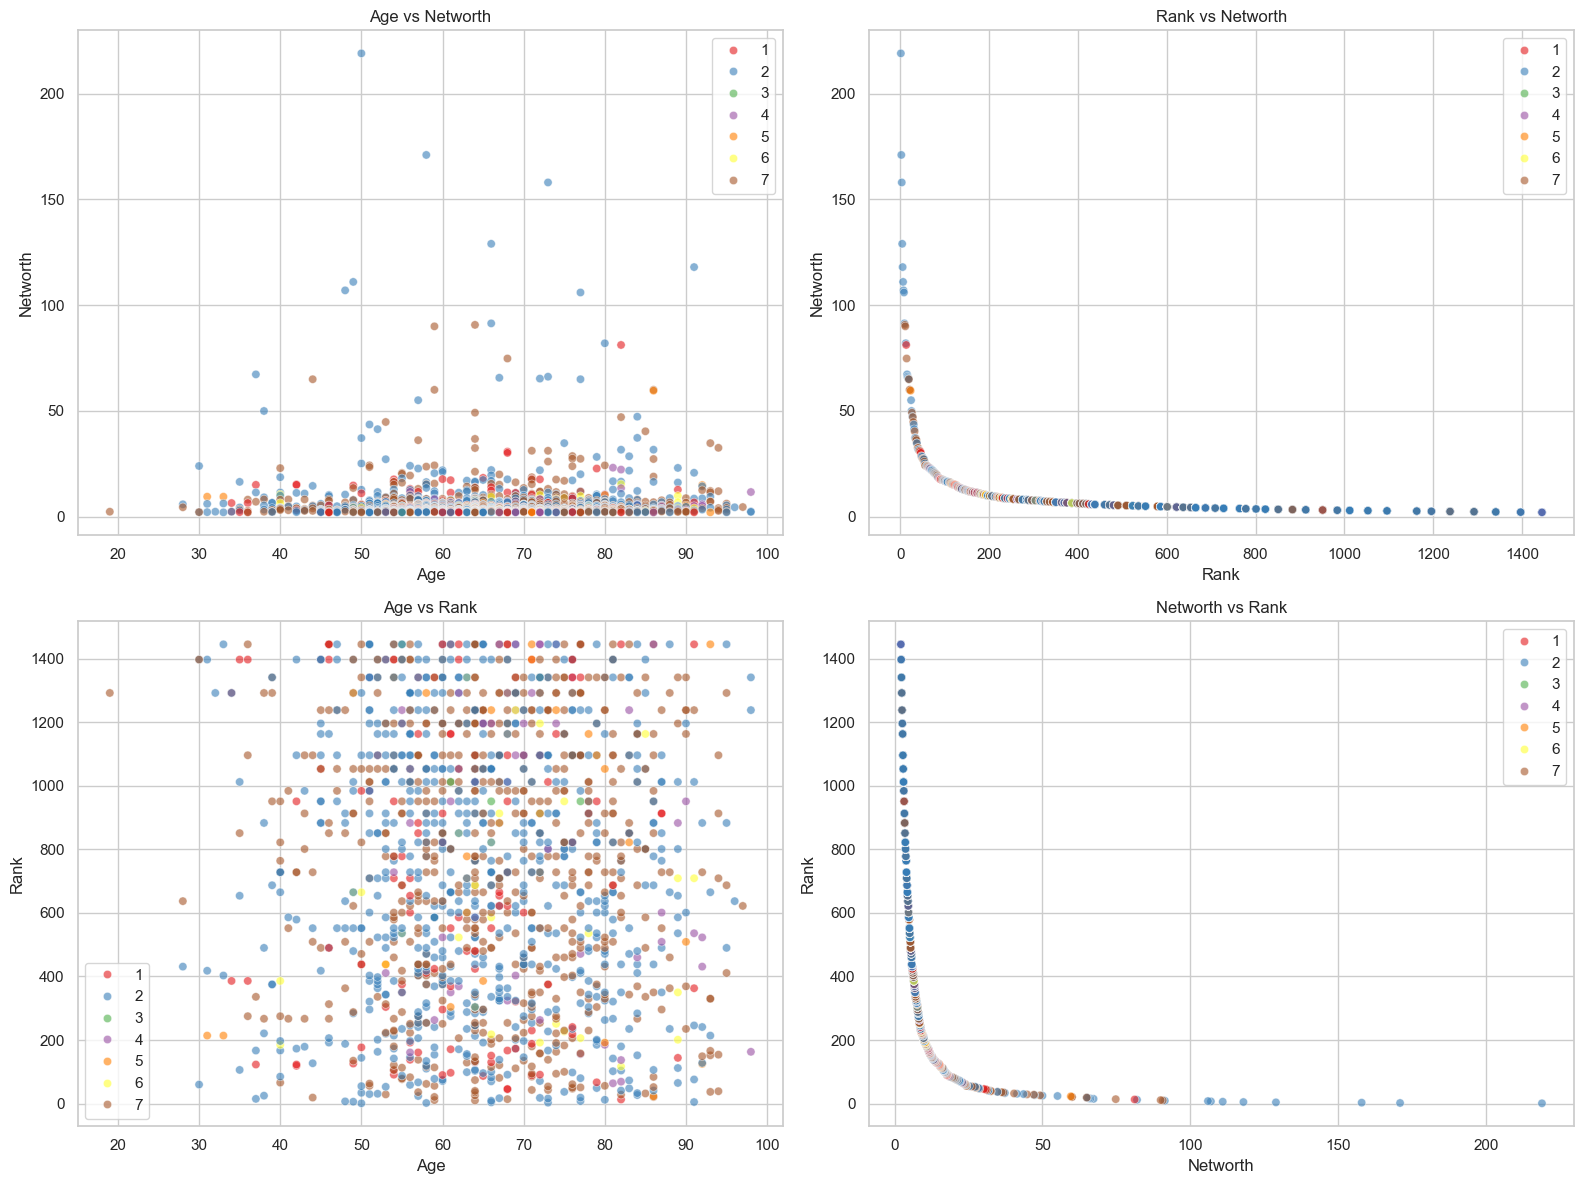

In [35]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
sns.scatterplot(x=df_cleaned['Age'], y=df_cleaned['Networth'], hue=result, palette='Set1', alpha=0.6)
plt.title('Age vs Networth')

plt.subplot(2, 2, 2)
sns.scatterplot(x=df_cleaned['Rank'], y=df_cleaned['Networth'], hue=result, palette='Set1', alpha=0.6)
plt.title('Rank vs Networth')

plt.subplot(2, 2, 3)
sns.scatterplot(x=df_cleaned['Age'], y=df_cleaned['Rank'], hue=result, palette='Set1', alpha=0.6)
plt.title('Age vs Rank')

plt.subplot(2, 2, 4)
sns.scatterplot(x=df_cleaned['Networth'], y=df_cleaned['Rank'], hue=result, palette='Set1', alpha=0.6)
plt.title('Networth vs Rank')

plt.tight_layout()
plt.show()

# KMeans (неиерархическая кластеризация) для сравнения

Неиерархическая кластеризация — метод группировки данных, при котором объекты распределяются по заданному числу кластеров(в нашем случае - 
𝑘 в методе K-Means), основываясь на определенных метриках расстояния или схожести. В отличие от иерархической кластеризации, которая создает древовидную структуру кластеров, неиерархическая работает с фиксированным количеством кластеров и напрямую распределяет объекты в группы.

K-Means:
* Один из самых популярных методов.
* Делит данные на 𝑘 кластеров, минимизируя сумму квадратов расстояний от каждой точки до её центроида.
* Центроиды обновляются итеративно, пока результат не стабилизируется.

Центры кластеров:
 [[ 7.20926316e+02  6.21684211e+00  6.75894737e+01  7.58941521e-19
   8.67361738e-19  0.00000000e+00  4.33680869e-18  1.05263158e-02
   1.05263158e-02 -1.38777878e-17  2.42861287e-17  5.26315789e-02
   1.11022302e-16  4.21052632e-02 -1.30104261e-18 -2.60208521e-18
  -1.73472348e-18  2.16840434e-18  1.08420217e-19 -5.42101086e-19
   3.46944695e-18  1.05263158e-02  7.78947368e-01 -4.33680869e-19
   1.05263158e-02 -3.46944695e-18 -1.08420217e-19  2.77555756e-17
   1.73472348e-18  5.20417043e-18 -8.67361738e-18 -1.38777878e-17
  -1.38777878e-17  4.21052632e-02  4.33680869e-19  3.25260652e-19
   2.60208521e-18  7.80625564e-18  4.33680869e-19  5.20417043e-18
   2.10526316e-02 -1.73472348e-18 -4.33680869e-18  0.00000000e+00
   1.05263158e-02  3.46944695e-18  0.00000000e+00 -2.16840434e-19
   4.33680869e-19 -5.42101086e-19 -6.93889390e-18  1.73472348e-18
   1.30104261e-18 -8.67361738e-18  0.00000000e+00  6.93889390e-18
   1.04083409e-17 -1.04083409e-17  1.73472348e-18  1.7347

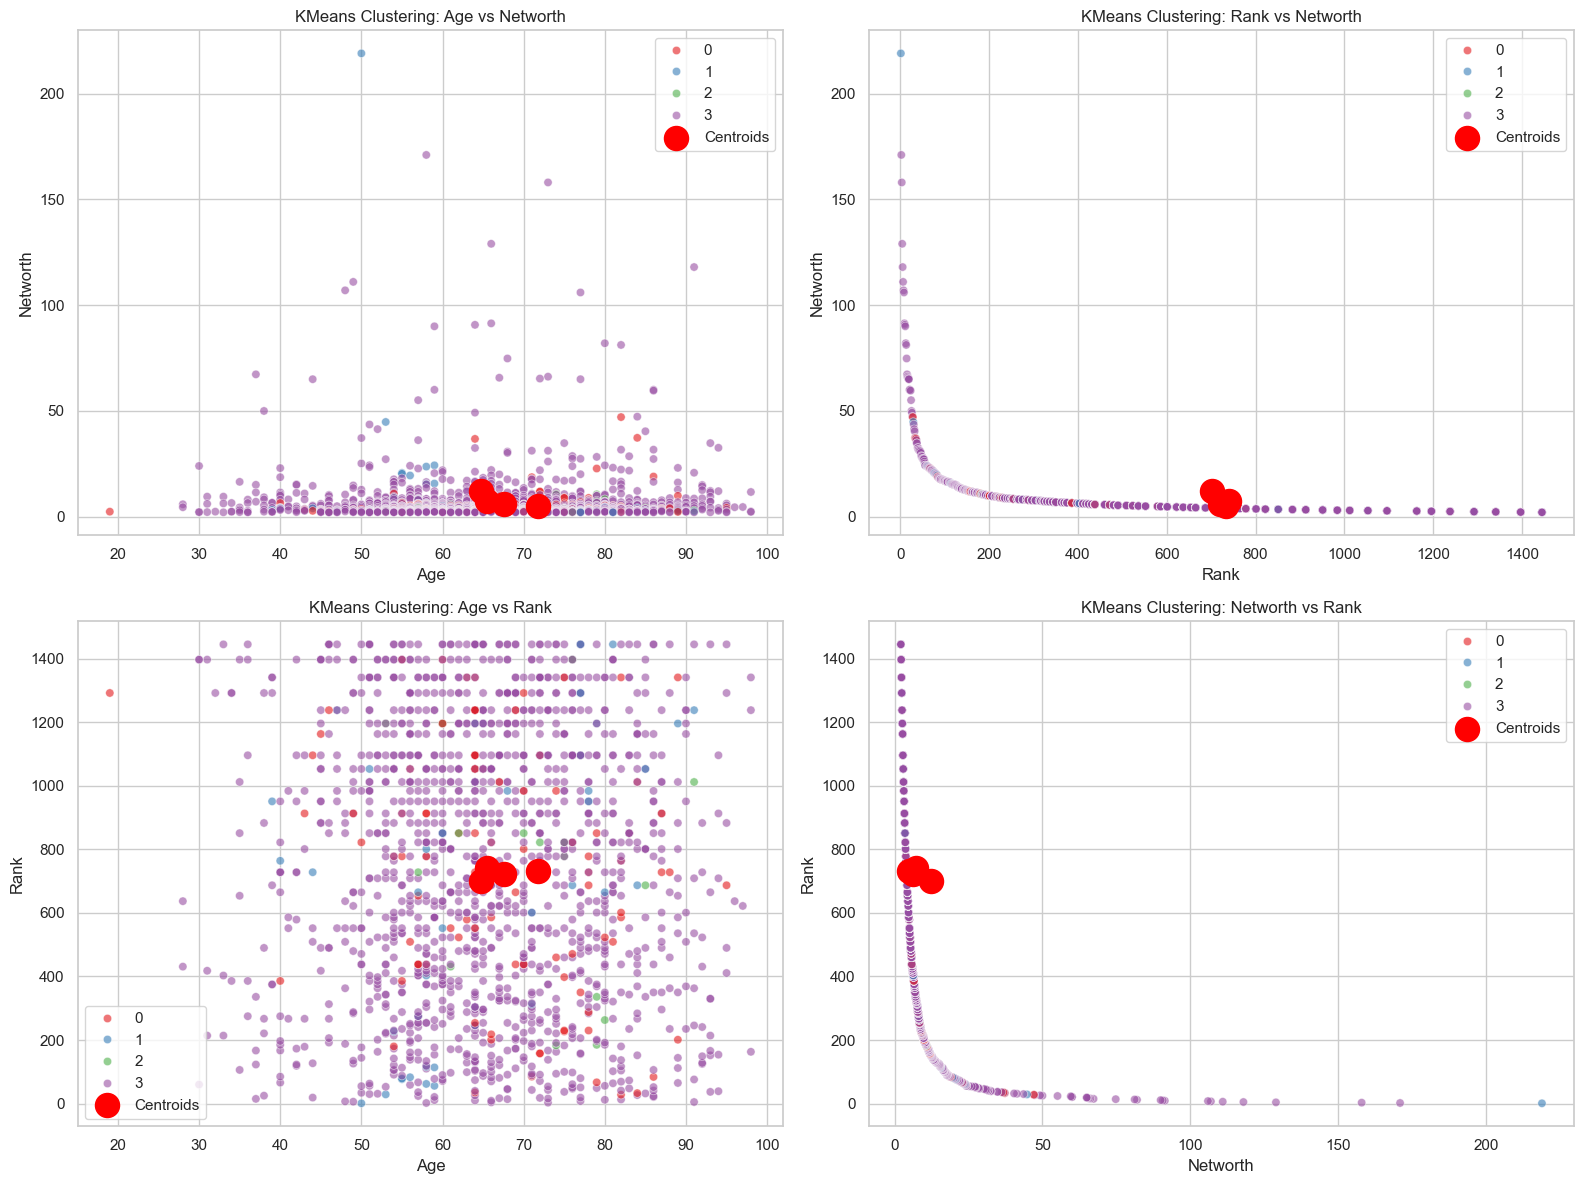

In [44]:
# Параметры для KMeans
random_state = 17
n_clusters = 4

# Применение KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
labels = kmeans.fit_predict(data_scaled)
centers = kmeans.cluster_centers_

# Обратная стандартизация центроидов
centers = scaler.inverse_transform(centers)
print("Центры кластеров:\n", centers)

# Добавление меток кластеров в DataFrame для удобства
df_cleaned['Cluster'] = labels

# Визуализация результатов кластеризации KMeans
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
sns.scatterplot(x=df_cleaned['Age'], y=df_cleaned['Networth'], hue=df_cleaned['Cluster'], palette='Set1', alpha=0.6)
plt.scatter(centers[:, 2], centers[:, 1], s=300, c='red', label='Centroids')
plt.title('KMeans Clustering: Age vs Networth')
plt.legend()

plt.subplot(2, 2, 2)
sns.scatterplot(x=df_cleaned['Rank'], y=df_cleaned['Networth'], hue=df_cleaned['Cluster'], palette='Set1', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', label='Centroids')
plt.title('KMeans Clustering: Rank vs Networth')
plt.legend()

plt.subplot(2, 2, 3)
sns.scatterplot(x=df_cleaned['Age'], y=df_cleaned['Rank'], hue=df_cleaned['Cluster'], palette='Set1', alpha=0.6)
plt.scatter(centers[:, 2], centers[:, 0], s=300, c='red', label='Centroids')
plt.title('KMeans Clustering: Age vs Rank')
plt.legend()

plt.subplot(2, 2, 4)
sns.scatterplot(x=df_cleaned['Networth'], y=df_cleaned['Rank'], hue=df_cleaned['Cluster'], palette='Set1', alpha=0.6)
plt.scatter(centers[:, 1], centers[:, 0], s=300, c='red', label='Centroids')
plt.title('KMeans Clustering: Networth vs Rank')
plt.legend()

plt.tight_layout()
plt.show()


# PCA для визуализации сокращенной размерности

PCA (Principal Component Analysis) — метод сокращения размерности, используемый для преобразования высокоразмерных данных в пространство с меньшим количеством измерений, сохраняя при этом как можно больше информации (дисперсии) из исходных данных.

В контексте графиков для визуализации результатов кластеризации, PCA используется для проекции многомерных данных в двумерное пространство, чтобы можно было легко визуализировать кластеры.

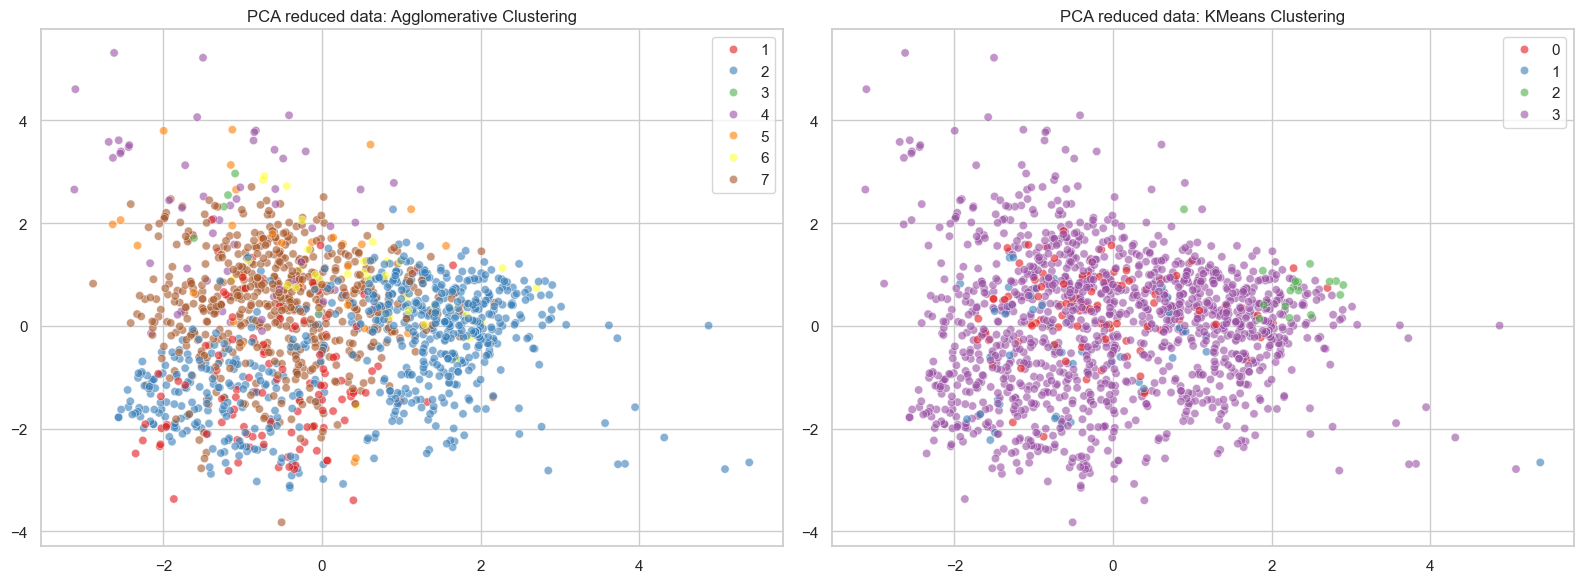

In [45]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_scaled)

# Визуализация сокращенных данных
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=result, palette='Set1', alpha=0.6)
plt.title('PCA reduced data: Agglomerative Clustering')

plt.subplot(1, 2, 2)
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette='Set1', alpha=0.6)
plt.title('PCA reduced data: KMeans Clustering')

plt.tight_layout()
plt.show()

# Анализ инерции для метода локтя (метод оценки суммы квадратов расстояний)

Анализ инерции для метода локтя — это техника, используемая для определения оптимального числа кластеров в задаче кластеризации (например, для алгоритма K-Means). Метод основывается на оценке суммы квадратичных отклонений (или инерции) объектов от центров их кластеров.

Инерция (в контексте кластеризации) — это метрика, которая измеряет "плотность" кластеров, то есть, насколько близко точки внутри каждого кластера расположены к его центроиду.
Формально инерция определяется как сумма квадратов расстояний всех точек до ближайшего центра кластера.

Метод локтя:
1. Для различных значений 𝑘 (количества кластеров) вычисляется инерция.
2. Значения инерции отображаются на графике в зависимости от 𝑘.
3. Смотрится точка, после которой уменьшение инерции значительно замедляется. Эта точка называется локтем, и соответствующее значение 𝑘 считается оптимальным числом кластеров.

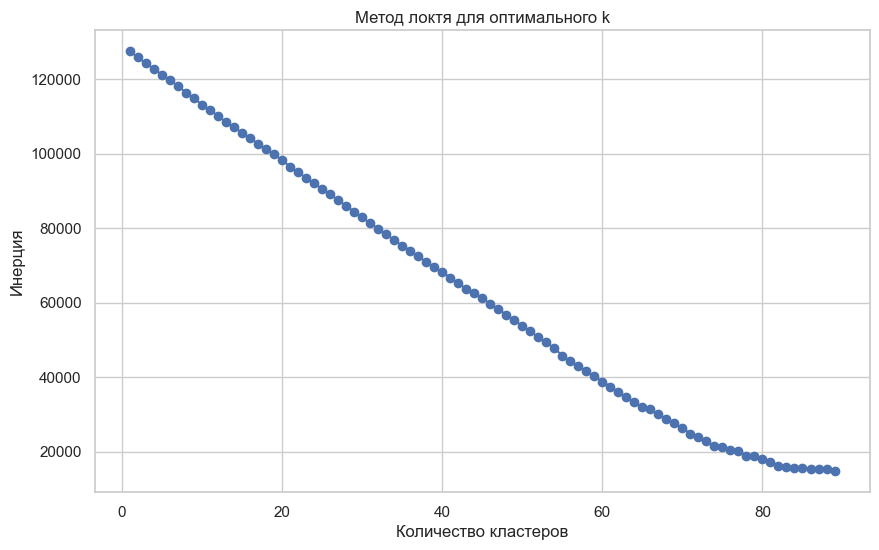

In [55]:
inertias = []
clusters_range = range(1, 90)
for i in clusters_range:
    kmeans = KMeans(n_clusters=i, random_state=random_state)
    kmeans.fit(data_scaled)
    inertias.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(clusters_range, inertias, marker='o')
plt.title('Метод локтя для оптимального k')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.grid(True)
plt.show()

Оптимальное кол-во кластеров - примерно 75-80.

# Расчитаем коэффициенты силуэта

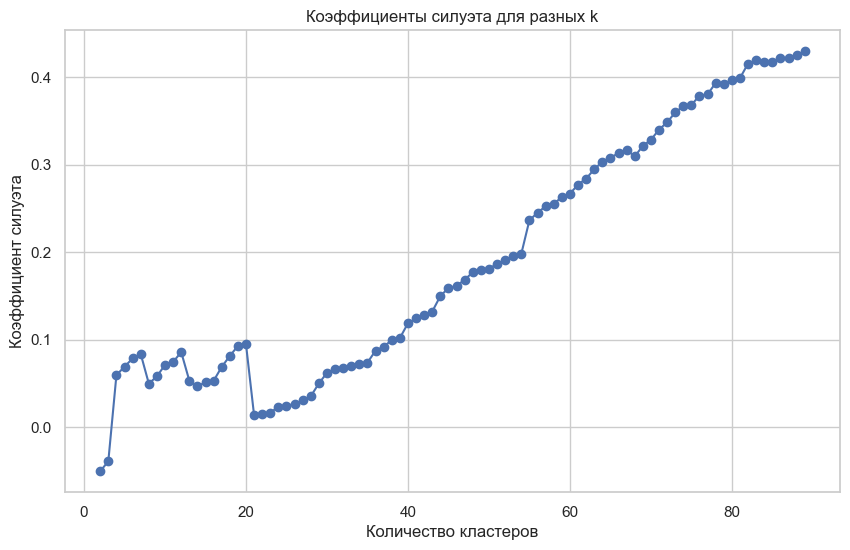

In [56]:
silhouette_scores = []
for i in clusters_range[1:]:  
    kmeans = KMeans(n_clusters=i, random_state=random_state)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)

# Построение диаграммы значений силуэта
plt.figure(figsize=(10, 6))
plt.plot(clusters_range[1:], silhouette_scores, marker='o')
plt.title('Коэффициенты силуэта для разных k')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.grid(True)
plt.show()

Средний коэффициент силуэта (silhouette score) используется для оценки качества кластеризации. Его значение лежит в диапазоне от -1 до 1. Что означают различные значения:

* Близко к 1.0 (0.7–1.0): Кластеры хорошо разделены и компактны. Это отличный результат кластеризации.

* От 0.5 до 0.7: Кластеры четко различимы, но есть некоторое пересечение между ними. Это хороший результат.
* От 0.25 до 0.5: Кластеры перекрываются, что указывает на менее четкую границу между группами. Качество кластеризации удовлетворительное, но может потребоваться уточнение числа кластеров или доработка данных.

* Близко к 0.0: Кластеры сильно перекрываются или распределение данных не позволяет выделить четкие группы. В этом случае нужно пересмотреть выбор числа кластеров, алгоритм или исходные данные.

* Меньше 0.0: Плохая кластеризация: точки ближе к центрам чужих кластеров, чем к своим. Это сигнал о том, что данные плохо структурированы для текущей кластеризации.

Средний коэффициент силуэта: 0.384


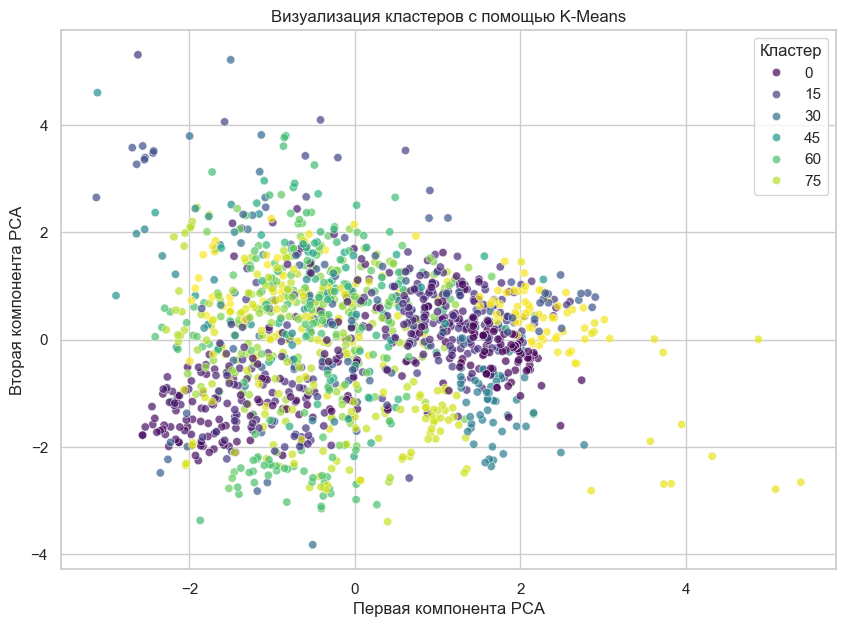

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Применение K-Means
kmeans = KMeans(n_clusters=85, random_state=42)  
df_clusters = kmeans.fit_predict(data_scaled)

# Оценка качества кластеризации
silhouette_avg = silhouette_score(data_scaled, df_clusters)
print(f'Средний коэффициент силуэта: {silhouette_avg:.3f}')

# Визуализация кластеров
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_clusters, palette='viridis', alpha=0.7)
plt.title('Визуализация кластеров с помощью K-Means')
plt.xlabel('Первая компонентa PCA')
plt.ylabel('Вторая компонентa PCA')
plt.legend(title='Кластер', loc='upper right')
plt.show()

Результат неплохой, показывает умеренно хорошую кластеризацию.